<a href="https://colab.research.google.com/github/macrotentional/DS-Unit-2-Linear-Models/blob/master/Martin_Campbell_DS15_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [x] Begin with baselines for classification.
- [x] Use scikit-learn for logistic regression.
- [x] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [x] Get your model's test accuracy. (One time, at the end.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [9]:
df.describe

<bound method NDFrame.describe of         Burrito       Date  Yelp  Google  ... Avocado  Corn  Zucchini  Great
0    California  1/18/2016   3.5     4.2  ...     NaN   NaN       NaN  False
1    California  1/24/2016   3.5     3.3  ...     NaN   NaN       NaN  False
2      Carnitas  1/24/2016   NaN     NaN  ...     NaN   NaN       NaN  False
3         Asada  1/24/2016   NaN     NaN  ...     NaN   NaN       NaN  False
4    California  1/27/2016   4.0     3.8  ...     NaN   NaN       NaN   True
..          ...        ...   ...     ...  ...     ...   ...       ...    ...
418       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN  False
419       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN   True
420  California  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN  False
421       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN   True
422       Other  8/27/2019   NaN     NaN  ...     NaN   NaN       NaN   True

[421 rows x 59 columns]>

In [11]:
df.dtypes

Burrito            object
Date               object
Yelp              float64
Google            float64
Chips              object
Cost              float64
Hunger            float64
Mass (g)          float64
Density (g/mL)    float64
Length            float64
Circum            float64
Volume            float64
Tortilla          float64
Temp              float64
Meat              float64
Fillings          float64
Meat:filling      float64
Uniformity        float64
Salsa             float64
Synergy           float64
Wrap              float64
Unreliable         object
NonSD              object
Beef               object
Pico               object
Guac               object
Cheese             object
Fries              object
Sour cream         object
Pork               object
Chicken            object
Shrimp             object
Fish               object
Rice               object
Beans              object
Lettuce            object
Tomato             object
Bell peper         object
Carrots     

In [13]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


# 1. **Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.**

In [17]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Burrito                   object
Date              datetime64[ns]
Yelp                     float64
Google                   float64
Chips                     object
Cost                     float64
Hunger                   float64
Mass (g)                 float64
Density (g/mL)           float64
Length                   float64
Circum                   float64
Volume                   float64
Tortilla                 float64
Temp                     float64
Meat                     float64
Fillings                 float64
Meat:filling             float64
Uniformity               float64
Salsa                    float64
Synergy                  float64
Wrap                     float64
Unreliable                object
NonSD                     object
Beef                      object
Pico                      object
Guac                      object
Cheese                    object
Fries                     object
Sour cream                object
Pork                      object
Chicken   

In [18]:
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [27]:
train = df[df.Date < '2017-01-01']
validate = df[(df.Date >= '2017-01-01') & (df.Date < '2018-01-01')]
test = df[df.Date > '2018-01-01']

print('Train dataset:',train.shape)
print('Validiate dataset:',validate.shape)
print('Test dataset:',test.shape)

Train dataset: (298, 59)
Validiate dataset: (85, 59)
Test dataset: (38, 59)


# 2. **Begin with baselines for classification.**

In [34]:
print('Train baseline:',train['Great'].mean())
print('Validiate baseline:',validate['Great'].mean())
print('Test baseline:',test['Great'].mean())

Train baseline: 0.40939597315436244
Validiate baseline: 0.4470588235294118
Test baseline: 0.5789473684210527


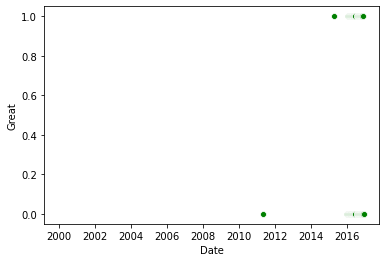

In [37]:
x = train['Great']
y = validate['Great']
z = test['Great']
d = df['Date']


import seaborn as sns
sns.scatterplot(d, x, color='green');

In [38]:
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

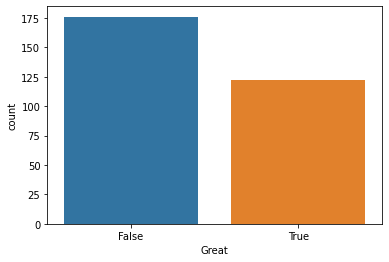

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.countplot(y_train);

In [49]:
target = 'Great'
y_validate = validate[target]
y_validate.value_counts(normalize=True)

False    0.552941
True     0.447059
Name: Great, dtype: float64

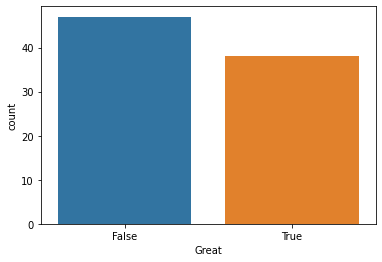

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.countplot(y_train);

In [40]:
train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,71.000000,71.000000,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,0.0
mean,3.897183,4.142254,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN
std,0.478680,0.371738,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [46]:
train.describe(include='number')


,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,71.000000,71.000000,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,0.0
mean,3.897183,4.142254,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN
std,0.478680,0.371738,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [45]:
train.describe(exclude='number')


,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,298,298,22,27,5,168,143,139,149,119,85,43,20,20,5,33,32,11,7,7,1,7,37,6,15,17,4,7,1,4,4,1,4,3,3,2,13,2,1,298
unique,5,110,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1,2
top,California,2016-08-30 00:00:00,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,False
freq,118,29,19,27,3,130,115,101,121,97,63,29,19,17,3,24,24,9,5,4,1,5,33,5,9,9,3,5,1,4,4,1,4,3,3,2,13,1,1,176
first,NaN,2011-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#datasubset = df.drop(['Mass (g)', 'Density (g/mL)', 'Queso'], axis=1)


In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298 entries, 0 to 300
Data columns (total 59 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Burrito         298 non-null    object        
 1   Date            298 non-null    datetime64[ns]
 2   Yelp            71 non-null     float64       
 3   Google          71 non-null     float64       
 4   Chips           22 non-null     object        
 5   Cost            292 non-null    float64       
 6   Hunger          297 non-null    float64       
 7   Mass (g)        0 non-null      float64       
 8   Density (g/mL)  0 non-null      float64       
 9   Length          175 non-null    float64       
 10  Circum          174 non-null    float64       
 11  Volume          174 non-null    float64       
 12  Tortilla        298 non-null    float64       
 13  Temp            283 non-null    float64       
 14  Meat            288 non-null    float64       
 15  Fillin

# 3. **Use scikit-learn for logistic regression.**

In [91]:
features = ['Yelp', 'Google', 'Cost', 'Temp', 'Synergy', 'Uniformity']
target = 'Great'

X_train = train[features]
y_train = train[target]

X_validate = validate[features]
y_validate = validate[target]

X_train.shape, y_train.shape, X_validate.shape, y_validate.shape

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_validate)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

X_train_encoded.head()

,Yelp,Google,Cost,Temp,Synergy,Uniformity
0,3.5,4.2,6.49,5.0,4.0,4.0
1,3.5,3.3,5.45,3.5,2.5,4.0
2,NaN,NaN,4.85,2.0,3.0,4.0
3,NaN,NaN,5.25,2.0,4.0,5.0
4,4.0,3.8,6.59,5.0,4.5,5.0


In [54]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_val_scaled)
accuracy_score(y_validate, y_pred)

0.7764705882352941

In [76]:
y_pred = model.predict(X_train_scaled)
y_pred

array([ True, False, False, False,  True,  True, False, False,  True,
       False, False, False, False,  True, False,  True,  True,  True,
        True, False, False,  True, False,  True,  True, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False,  True, False, False,  True, False,  True,
       False, False, False, False, False,  True,  True, False,  True,
        True, False, False, False,  True,  True,  True, False, False,
       False,  True, False,  True,  True,  True,  True,  True, False,
        True,  True, False, False, False, False, False, False, False,
        True,  True,  True, False,  True, False,  True, False, False,
       False, False, False,  True, False,  True,  True,  True,  True,
       False, False, False,  True, False,  True,  True,  True,  True,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False,  True, False,  True,  True, False, False,
       False, False,

In [77]:
accuracy_score(y_train, y_pred)

0.8355704697986577

In [60]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients

Yelp          0.212833
Google       -0.039565
Cost          0.512049
Temp          0.564250
Synergy       2.380394
Uniformity    0.533250
dtype: float64

# 4. **Get your model's validation accuracy. (Multiple times if you try multiple iterations.)**

In [65]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_validate))

Validation Accuracy 0.7647058823529411


In [0]:
# copied from Titanic example

# 1. Import estimator class
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
linear_reg = LinearRegression()

# 3. Arrange X feature matrices (already did y target vectors)
features = ['Pclass', 'Age', 'Fare']
X_train = train[features]
X_val = val[features]

# Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

# 4. Fit the model
linear_reg.fit(X_train_imputed, y_train)

# 5. Apply the model to new data.
# The predictions look like this ...
linear_reg.predict(X_val_imputed)

# 5. **Get your model's test accuracy. (One time, at the end.)**

In [106]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

X_train_encoded.head()

,Yelp,Google,Cost,Temp,Synergy,Uniformity
0,3.5,4.2,6.49,5.0,4.0,4.0
1,3.5,3.3,5.45,3.5,2.5,4.0
2,NaN,NaN,4.85,2.0,3.0,4.0
3,NaN,NaN,5.25,2.0,4.0,5.0
4,4.0,3.8,6.59,5.0,4.5,5.0


In [107]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
y_pred = model.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.7631578947368421